In [3]:
#4qubitのHardware Efficent(HWE)回路
import pennylane as qml
import numpy as np
from math import pi
import matplotlib.pyplot as plt

n_wires = 4
dev = qml.device('default.qubit', wires=n_wires)

#HWE
@qml.qnode(dev)
def circuit(weights_gen , params_rand):
    layers = weights_gen.shape[0]

    #ランダムな積状態を生成
    for i in range(n_wires):
        qml.RZ(params_rand[i][1], wires=i)
        qml.RY(params_rand[i][0], wires=i)

    #HWE
    for d in range(layers):
        for i in range(n_wires):
            qml.U3(weights_gen[d][i][0],weights_gen[d][i][1],weights_gen[d][i][2], wires=i)

        for i in range(int(n_wires/2)):
            qml.CZ(wires=[2*i,2*i+1])

        for i in range(n_wires):
            qml.U3(weights_gen[d][i][0],weights_gen[d][i][1],weights_gen[d][i][2], wires=i)
        
        for i in range(int((n_wires-1)/2)):
            qml.CZ(wires=[2*i+1,2*i+2])

    return qml.state()

#Concentratable Entanglementの計算
def concentratable_entanglement(state):
    power_set = []
    for i in range(1,2**n_wires): 
        subset = [j for j in range(n_wires) if (i & (1 << j))]
        power_set.append(subset)

    purity_sum  = 0
    #部分系の密度行列の純粋度の和
    for subset in power_set:
        rho = qml.math.reduce_statevector(state,subset)
        trace = np.trace(rho @ rho).real
        purity_sum += trace
    #空集合の場合
    purity_sum += 1

    CE = 1 - ( 1 / (2**n_wires))  * purity_sum
    return  CE

0: ──RZ(5.62)──RY(5.72)──U3(0.02,-0.44,-0.44)──╭●──U3(0.02,-0.44,-0.44)───U3(0.10,-0.42,-0.45)
1: ──RZ(2.21)──RY(3.94)──U3(-0.12,-0.29,-0.26)─╰Z──U3(-0.12,-0.29,-0.26)─╭●───────────────────
2: ──RZ(6.17)──RY(1.77)──U3(-0.31,0.50,0.43)───╭●──U3(-0.31,0.50,0.43)───╰Z───────────────────
3: ──RZ(0.51)──RY(1.97)──U3(0.29,0.53,-0.10)───╰Z──U3(0.29,0.53,-0.10)────U3(0.33,0.42,0.55)──

──────────────────────╭●──U3(0.10,-0.42,-0.45)──U3(0.18,-0.42,-0.50)───────────────────────╭●
───U3(0.06,0.36,0.35)─╰Z──U3(0.06,0.36,0.35)───╭●─────────────────────U3(0.13,0.38,0.41)───╰Z
───U3(0.02,0.13,0.68)─╭●──U3(0.02,0.13,0.68)───╰Z─────────────────────U3(0.07,-0.19,-0.00)─╭●
──────────────────────╰Z──U3(0.33,0.42,0.55)────U3(0.35,0.46,0.46)─────────────────────────╰Z

───U3(0.18,-0.42,-0.50)──U3(0.19,-0.45,-0.51)────────────────────────╭●──U3(0.19,-0.45,-0.51)─
───U3(0.13,0.38,0.41)───╭●─────────────────────U3(0.13,-0.65,-0.66)──╰Z──U3(0.13,-0.65,-0.66)─
───U3(0.07,-0.19,-0.00)─╰Z─────────────────────U3(-0

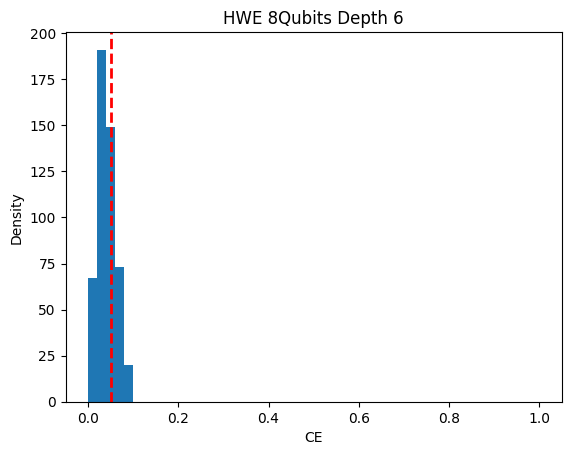

In [5]:
#CEの分布の確認用のコード
#HWE回路のパラメータの読み込み（Depth=6,CE=0.05）
weights_gen = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_5_6_weights.npy')

x=[]

#回路の描画
print(qml.draw(circuit)(weights_gen, np.random.uniform(0, 2 * np.pi, (n_wires, 2))) )       

for i in range(500):
    params_rand = np.random.uniform(0, 2 * np.pi, (n_wires, 2))
    state = circuit(weights_gen, params_rand)
    x.append(concentratable_entanglement(state))
    
    print(i, x[i])


plt.hist(x,bins=50,range=(0, 1.0))
plt.title("HWE 8Qubits Depth 6")
plt.xlabel('CE')
plt.ylabel('Density')
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=2, label=f'Theoretical mean: {0.05}')

print("平均", np.mean(x))

plt.show()

In [6]:
#データセットの出力
#ここでは, CEが0.05,0.35のデータセットを作成する
#入力= ランダムな積状態を作りだすためのパラメータ, 出力= HWEを作用させてできる状態のCEの理論値に対応する値 -1 or 1
import csv 
import random 

#HWE回路のパラメータ読み込み
weights_005= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_5_6_weights.npy')
weights_035= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_35_6_weights.npy')

#CEの理論値
optimal_ce_005 = 0.05
optimal_ce_035 = 0.35


#データセットの個数指定
trainDataQuantities = 240
testDataQuantities = 60

#flag = True ならtrainデータセットを作成, Falseならtestデータセットを作成
flag = False

#ファイル名を指定
if flag:
    print("create train dataset")
    array = [-1] * int(trainDataQuantities /2 ) + [1] * int(trainDataQuantities /2)
    file_name = 'train_HWE_4q_6_005_035_no4.csv'
    count_limit = trainDataQuantities
else: 
    print("create test dataset")
    array = [-1] * int(trainDataQuantities /2 ) + [1] * int(trainDataQuantities /2)
    file_name = 'test_HWE_4q_6_005_035_no4.csv'
    count_limit = testDataQuantities

random.shuffle(array)

count = 0

with open(file_name, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    while count < count_limit:
        if array[count] == -1:
            optimal_ce = optimal_ce_005
            weights = weights_005
        else:
            optimal_ce = optimal_ce_035
            weights = weights_035
        
        #ランダムな積状態を作るためのパラメータ
        params_rand = np.random.uniform(0, 2 * np.pi, (4, 2))

        state = circuit(weights, params_rand)
        CE = concentratable_entanglement(state)

        #CEが理論値の範囲内ならデータセットに追加
        if(abs(CE - optimal_ce) <= 0.1):
            tmp_csv  = params_rand.flatten()
            if array[count] == -1:
                tmp_csv = np.append(tmp_csv,-1)
                tmp_csv = np.append(tmp_csv,-1)
            else:
                tmp_csv = np.append(tmp_csv,1)
                tmp_csv = np.append(tmp_csv,1)

            writer.writerow(tmp_csv)
            count += 1
            #print(count,CE)
        else:
            continue

create test dataset
